In [64]:
import torch
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
import os
from datetime import datetime
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings("ignore")

In [80]:
# Tokenize and encode the sentences
class MyDataset(Dataset):
    def __init__(self, e1, e2, sentence , tokenizer, max_len):
        self.e1 = e1
        self.e2 = e2 
        self.sentence = sentence 
        self.tokenizer = tokenizer 
        self.max_len = max_len

    def __len__(self):
          return 1 

    def __getitem__(self, index):
        if self.sentence == None: 
            input_text = f"{self.e1} [SEP] {self.e2}"
        else:
            input_text = f"{self.sentence} [SEP] {self.e1} [SEP] {self.e2}"

        encoding = self.tokenizer.encode_plus(
            input_text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': input_text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

In [81]:
test_dataset = MyDataset( e1 = "Barack Obama", e2 = "Michelle Obama", sentence = "Barack Obama is married to Michelle Obama.", tokenizer = tokenizer, max_len = 128)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True )

In [82]:
class BertSentimentClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BertSentimentClassifier, self).__init__()

        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 256)
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, num_classes)


    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout1(pooled_output)
        output = self.fc1(pooled_output)
        output = self.dropout2(output)
        logits = self.fc2(output)

        return logits

In [94]:
def load_bert_model(weight_path, bert_model_name):

    num_classes = 6
    model_predict = BertSentimentClassifier(bert_model_name, num_classes)
    model_predict.load_state_dict(torch.load(weight_path, map_location=torch.device('cpu')))
    tokenizer = BertTokenizer.from_pretrained(bert_model_name) 
    return model_predict, tokenizer


weight_path = "Model_BERT_1_270/final_model_BERT1.pt" 
bert_model_name = "alvaroalon2/biobert_diseases_ner"
# bert_model_name = "bert-base-uncased"
model_predict, tokenizer = load_bert_model(weight_path, bert_model_name)

Some weights of BertModel were not initialized from the model checkpoint at alvaroalon2/biobert_diseases_ner and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [95]:
model_predict = load_bert_model(weight_path, bert_model_name)

for data in test_loader:
    input_ids = data["input_ids"]
    attention_mask = data["attention_mask"]
    logits = model_predict(input_ids, attention_mask)

    # Get predicted labels and probabilities
    predicted_labels = torch.argmax(logits, dim=1).tolist()[0]
    predicted_probs = torch.nn.functional.softmax(logits, dim=1)[0].tolist()

    # Check if the prediction is false (label 5)
    if predicted_labels == 0 :
        # Penalize false prediction by reducing probabilities
        predicted_probs = [(prob * 0.8) for prob in predicted_probs]

        # Identify the second best class with highest probability
        second_best_index = sorted(range(len(predicted_probs)), key=predicted_probs.get, reverse=True)[1]
        second_best_prob = predicted_probs[second_best_index]

        # Increase the probability of the second best class
        predicted_probs[second_best_index] += 0.2

        # Update the predicted label based on the adjusted probabilities
        predicted_labels = torch.argmax(predicted_probs, dim=1).tolist()[0]

Some weights of BertModel were not initialized from the model checkpoint at alvaroalon2/biobert_diseases_ner and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: 'tuple' object is not callable

false
[0.970928430557251, 0.004575161729007959, 0.01332778763025999, 0.007972477003932, 0.0031905861105769873, 5.627837253996404e-06]


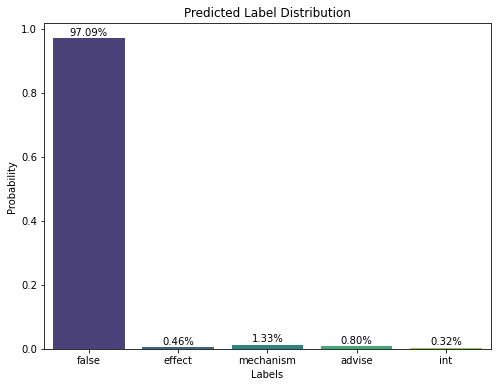

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
labels = ["false", "effect", "mechanism", "advise", "int"]  
for data in test_loader:
    input_ids = data["input_ids"]
    attention_mask = data["attention_mask"]
    logits = model_predict(input_ids, attention_mask)
    # Get predicted labels
    # predicted_labels = torch.argmax(logits, dim=1).tolist()
    predicted_labels = torch.argmax(logits, dim=1).tolist()[0] 
    print(labels[predicted_labels]) 
    probs = torch.nn.functional.softmax(logits, dim=1)[0].tolist()

    print(probs)
# Filter out class 5
filtered_probs = [prob for i, prob in enumerate(probs) if i != 5]

# Create a list of labels excluding class 5
filtered_labels = labels

# Plot the distribution using seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=filtered_labels, y=filtered_probs, palette='viridis')
plt.xlabel('Labels')
plt.ylabel('Probability')
plt.title('Predicted Label Distribution')

# Display percentages on top of each bar
for i, prob in enumerate(filtered_probs):
    plt.text(i, prob + 0.01, f'{prob * 100:.2f}%', ha='center')

plt.show()

In [103]:
probs[0][0]

TypeError: 'float' object is not subscriptable

In [68]:
# The rest of your Streamlit app code
input_text = "Betaseron [SEP] antipyrine [SEP] Betaseron administration to three cancer patients over a dose range of 0.025 mg to 2.2 mg led to a dose-dependent inhibition of antipyrine elimination.14 The effect of alternate-day administration of 0.25 mg of Betaseron on drug metabolism in MS patients is unknown."
#input_text = "Betaseron [SEP] antipyrine"
max_len = 270
device = "cpu"
labels = ["false", "effect", "mechanism", "advise", "int"] 
encoded_input = tokenizer.encode_plus(
            input_text, 
            add_special_tokens=True,
            truncation=True,
            max_length= max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        ).to(device)
predict_id = torch.argmax(model_predict(**encoded_input), dim=1).item()
print(labels[predict_id]) 

mechanism


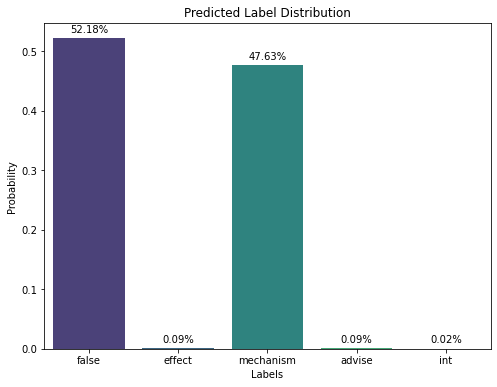

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# The rest of your code...

# Get the predicted label probabilities
probs = torch.nn.functional.softmax(model_predict(**encoded_input), dim=1)[0].tolist()

# Filter out class 5
filtered_probs = [prob for i, prob in enumerate(probs) if i != 5]

# Create a list of labels excluding class 5
filtered_labels = labels

# Plot the distribution using seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=filtered_labels, y=filtered_probs, palette='viridis')
plt.xlabel('Labels')
plt.ylabel('Probability')
plt.title('Predicted Label Distribution')

# Display percentages on top of each bar
for i, prob in enumerate(filtered_probs):
    plt.text(i, prob + 0.01, f'{prob * 100:.2f}%', ha='center')

plt.show()
